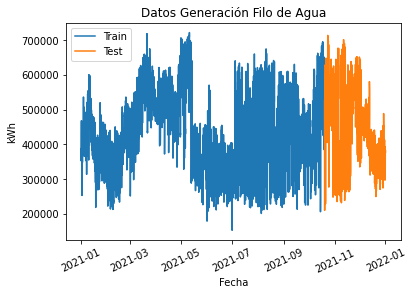

In [1]:
# Parte 1 - Preprocesado de los datos

# Importación de las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importar el dataset
df = pd.read_csv("DataGeneración_filo.csv")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.set_index("Fecha", inplace=True)

dataset_train = df.iloc[:7008,0].copy()  # 80%
training_set = dataset_train.values.reshape(-1,1)

dataset_test = df.iloc[7008:,0].copy()  # 20%
real = dataset_test.values.reshape(-1,1)

plt.title("Datos Generación Filo de Agua")
plt.ylabel("kWh")
plt.xlabel("Fecha")
plt.plot(df.index[:7008], dataset_train.values, label="Train")
plt.plot(df.index[7008:], dataset_test.values, label="Test")
plt.legend()
plt.xticks(rotation=25)
plt.show()

In [2]:
# Escalado de características
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Crear una estructura de datos con 60 timesteps y 1 salida
X_train = []
y_train = []
for i in range(60, 7008):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Redimensión de los datos
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [3]:
# Parte 2 - Construcción de la RNR
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout

# # Inicialización del modelo
# regressor = Sequential()

# # Añadir la primera capa de LSTM y la regulariación por Dropout
# regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
# regressor.add(Dropout(0.2))

# # Añadir la segunda capa de LSTM y la regulariación por Dropout
# regressor.add(LSTM(units = 50, return_sequences = True ))
# regressor.add(Dropout(0.2))

# # Añadir la tercera capa de LSTM y la regulariación por Dropout
# regressor.add(LSTM(units = 50, return_sequences = True ))
# regressor.add(Dropout(0.2))

# # Añadir la cuarta capa de LSTM y la regulariación por Dropout
# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.2))

# # Añadir la capa de salida
# regressor.add(Dense(units = 1))

# # Compilar la RNR
# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Ajustar la RNR al conjunto de entrenamiento
# regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

# Cargar modelo guardado
regressor = load_model("LSTM.h5")

In [4]:
# Descripción de la LSTM
regressor.summary()

# Guardar modelo
# regressor.save("LSTM.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [5]:
# Parte 3 - Ajustar las predicciones
# Obtener la predicción con la RNR
dataset_total = pd.concat((dataset_train, dataset_test))
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1752):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

In [7]:
# Parte 3 - Ajustar las predicciones (Usando predicciones como nuevas entradas)
# Obtener la predicción con la RNR
inputs  = real[:60].copy()
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs = np.array([inputs])
inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
predicted = []
for i in range(1752):
    new_prediction = regressor.predict(inputs)[0,0]
    predicted.append(new_prediction)

    temp_inputs = list(inputs[0,1:,0])
    temp_inputs.append(new_prediction)
    inputs = np.array([temp_inputs])
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    # inputs

In [8]:
predicted = np.reshape(np.array(predicted), (-1, 1))
predicted = sc.inverse_transform(predicted)

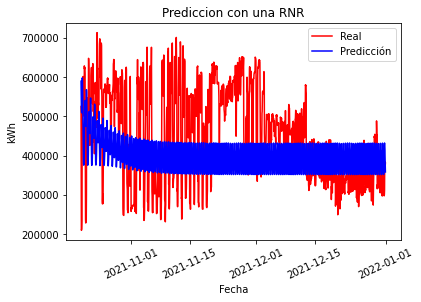

In [9]:
# Visualizar los Resultados
plt.plot(df.index[7008:], real, color = 'red', label = 'Real')
plt.plot(df.index[7008:], predicted, color = 'blue', label = 'Predicción')
plt.title("Prediccion con una RNR")
plt.xlabel("Fecha")
plt.ylabel("kWh")
plt.xticks(rotation=25)
plt.legend()
plt.show()

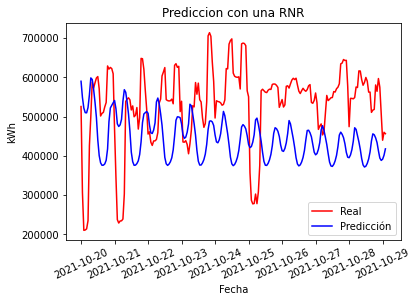

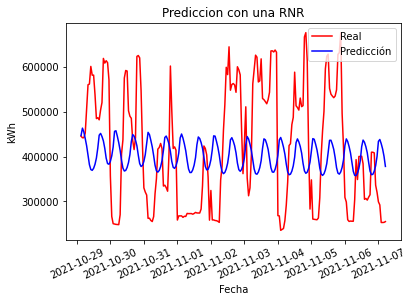

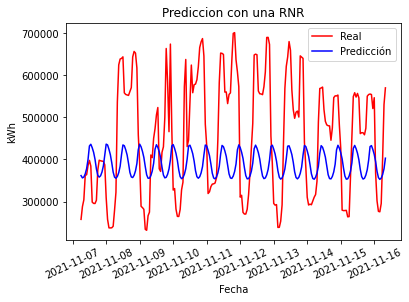

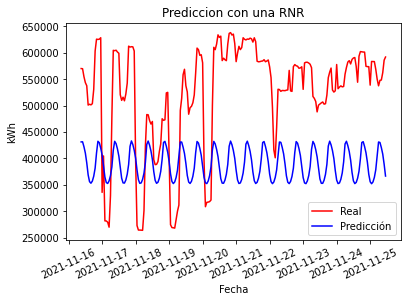

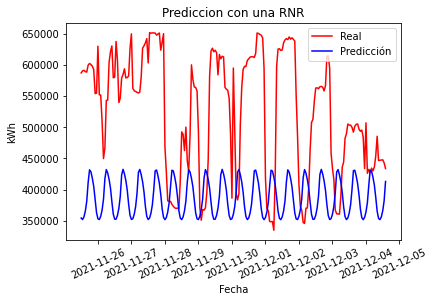

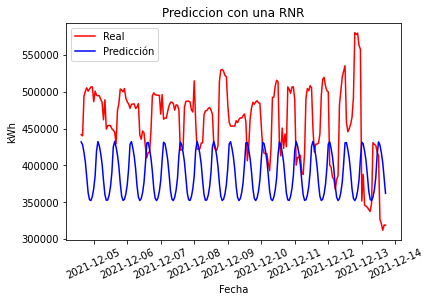

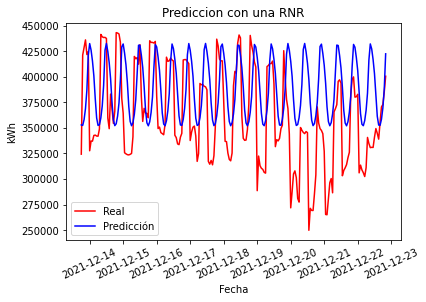

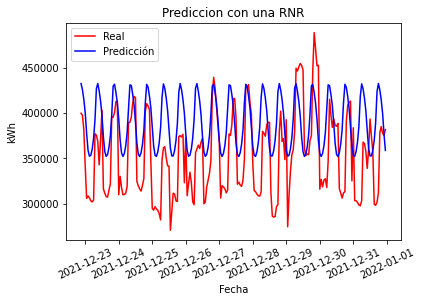

In [10]:
for i in range(1,9):
    plt.plot(df.index[7008+219*(i-1):7008+219*i], real[219*(i-1):219*i], color = 'red', label = 'Real')
    # if i == 8:
        # plt.plot(df.index[7008+219*(i-1):7008-60+219*i], predicted[219*(i-1):219*i], color = 'blue', label = 'Predicción')
    # else:
    plt.plot(df.index[7008+219*(i-1):7008+219*i], predicted[219*(i-1):219*i], color = 'blue', label = 'Predicción')
    plt.title("Prediccion con una RNR")
    plt.xlabel("Fecha")
    plt.ylabel("kWh")
    plt.xticks(rotation=25)
    plt.legend()
    plt.show()